# Projet  **<span style="color: #CC146C">Quiz generator </span>** 💡 - Python pour le data-scientist

#### Auteurs : Adrien Servière, Mélissa Tamine.

L'objectif de ce notebook est de présenter le projet que nous avons effectué dans le cadre de l'unité d'enseignement **Python pour le data-scientist** dispensée à l'ENSAE. Ce projet a été élaboré de manière libre et comporte, comme attendu, un **jeu de données** récupéré et traité, une partie **visualisation** et une partie **modélisation**. 

# Problématique

Notre projet s'articule autour de la problématique suivante : **Comment créer un système capable de générer un quiz (plusieurs paires de question/réponse) sur un thème précis ?**

Dans la mesure où l'objectif principal d'un quiz est d’évaluer les connaissances d’un participant, il nous a semblé qu'un tel système pourrait s'avérer très utile à des enseignants afin de tester de manière ludique les acquis de leurs élèves par exemple. 

C'est pourquoi nous avons modélisé la structure suivante afin que le système créé puisse répondre au problème :

![framework](./data/images/framework.png "Structure du système implémenté")

La structure est divisée en deux parties distinctes : 
1. Une partie **traitement des données** qui a principalement consisté à extraire et indexer dans ElasticSearch la base de données Wikipédia sur laquelle le modèle se fonde.
2. Une partie **modélisation** fondée sur la mise en place d'une *pipeline* formée de plusieurs outils de traitement du langage et modèles de langages.

# Installations et recommandations préalables

Avant d'exécuter veuillez procéder aux installations de modules nécessaires au bon fonctionnement du code en exécutant la cellule ci-dessous. 

In [29]:
#!pip install elasticsearch
#!pip install wordcloud
#!pip install torch
#!pip install nltk
#!pip install spacy
#!python3 -m spacy download en

De même, nous vous demanderons d'exécuter les cellules de ce notebook au sein d'un **espace de travail muni d'un service ElasticSearch préalablement exécuté** afin que la partie indexation puisse fonctionner. Nous vous conseillons d'utiliser **SSP Cloud** car la technologie ElasticSearch y est disponible.

# Importation des modules utiles

In [1]:
import os
import sys
import seaborn
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from src.models.bm25_retriever import *
from src.scripts.wikipedia_indexing import *
from src.data.constants import *
from src.data.visualisation import *

# Récupération et traitement des données 🗂️

## Extraction des données textuelles provenant de l'encyclopédie Wikipédia

La première étape de notre projet a été la **récupération** et le **traitement des données**. Dans notre cas, nous avons fait le choix de récupérer des données textuelles provenant d'articles de l'encyclopédie en ligne **Wikipédia**. 

Pour des raisons de volume, nous avons extrait les données brutes de la version en anglais simple de Wikipédia (en anglais : *Simple English Wikipedia*). Il s'agit d'une encyclopédie spécialement fondée pour « des étudiants, des enfants ou des adultes ayant des difficultés de compréhension et pour ceux qui souhaiteraient apprendre l'anglais ». En novembre 2021, date à laquelle nous avons extrait les données brutes, le site contenait plus de **200 000 pages** différentes.

Afin d'extraire ces données brutes et de les convertir en données textuelles pouvant être exploitées, nous avons utilisé l'outil ```Wikiextractor``` (https://attardi.github.io/wikiextractor/) de la manière suivante dans un terminal :
```
>>> wget "http://download.wikimedia.org/simplewiki/latest/simplewiki-latest-pages-articles.xml.bz2"

>>> python -m wikiextractor.WikiExtractor -o "./quiz-generator/data/wikipedia/" --json --processes 12 "quiz-generator/data/wikipedia/simplewiki-latest-pages-articles.xml.bz2"

>>> rm "./quiz-generator/data/wikipedia/simplewiki-latest-pages-articles.xml.bz2"
```

Ces commandes nous ont permis d'obtenir les plus de 200 000 pages de données textuelles sous la forme de plusieurs fichiers .txt formatés comme des données au format JSON que vous trouverez dans le dossier *data* du projet.

## Indexation des données textuelles dans ElasticSearch

Une fois les données récupérées, il a ensuite fallu les traiter. Le traitement a principalement consisté à indexer ces données textuelles dans *ElasticSearch*. 

ElasticSearch c’est un logiciel qui fournit un moteur de recherche installé sur un serveur (dans notre cas le serveur SSP Cloud) qu’il est possible de requêter depuis un client (ce Notebook en l'occurence). C’est un moteur de recherche très performant, puissant et flexible sur données textuelles. L'objectif de l'utilisation d'un tel outil est de trouver, dans un corpus de grande dimension, un certain texte. **Dans notre cas, il s'agit de trouver les textes les plus pertinents sur un thème donné parmi l'ensemble des données textuelles comprises dans les 200 000 pages de données disponibles.**

Nous utilisons la librairie python ```elasticsearch``` pour dialoguer avec notre moteur de recherche Elastic. La ligne de code ci-dessous permet d'établir la connexion avec le cluster Elastic que vous avez dû lancer dans votre session SSP Cloud lors de la phase de recommandation. 

In [2]:
es = set_es_client()

Maintenant que la connexion est établie, nous pouvons passer à l'étape **d'indexation**. Cette étape consiste à envoyer les documents parmi lesquels nous souhaitons chercher des echos pertinents dans notre elastic. Un index est donc une collection de document. Dans notre cas, les documents sont les paragraphes qui composent les articles du *Simple English Wikipedia*. 

**Remarque :** L'exécution de la ligne suivante qui permet l'indexation est relativement longue, veuillez compter environ 7 minutes.

In [40]:
#run_indexing(client=es, args=fill_default_args())

## Exécution d'une première requête test

Maintenant que l'étape d'indexation est finalisée, il est désormais possible de lancer notre première **requête** c'est à dire de chercher les documents les plus pertinents à propos d'un thème (un certain mot). 

Pour cela, nous utilisons l'algorithme BM25 que nous avons implémenté et qui utilise simplement la méthode interne de pondération des mots utilisée par ElasticSearch. La pertinence d’un mot pour notre recherche est construite sur une variante de la **TF-IDF**, considérant qu’un terme est pertinent s’il est souvent présent dans le document (Term Frequency) alors qu’il est peu fréquent dans les autres document (inverse document frequency).

In [3]:
bm25 = BM25Retriever(client=es)

Nous décidons par exemple de chercher les documents c'est à dire les paragraphes inclus dans le *Simple English Wikipedia* les plus pertinents traitant du philosophe **Emmanuel Kant**.

In [5]:
contexts = bm25.retrieve(query='kant')
text_contexts = [context.text for context in contexts]

In [6]:
nl = ' \n ------ \n'
print(f"{nl}{nl.join(text_contexts)}")

 
 ------ 
In the early 20th century Kant's ideas were very influential on one group of German philosophers. They became known as the new-Kantians. One of them, Windelband, said, "every philosophy before Kant poured into Kant, and every philosophy after Kant pours from Kant". 
 ------ 
Some scholars like to include Kant as one of the German idealists, but Kant himself did not belong to that group. 
 ------ 
The term was coined by Immanuel Kant. Kant said that moral values had to be unconditional, categorical; he wrote a categorical imperative. 
 ------ 
The most-known work of Kant is the book "Critique of Pure Reason" ("Kritik der reinen Vernunft") that Kant published in 1781. Kant called his way of thought "critique", not philosophy. Kant said that critique was a preparation for establishment of real philosophy. According to Kant, people should know what human reason can do and which limits it has. In the "Critique of Pure Reason" Kant wrote several limits of human reason, to both fee

Ces 10 paragraphes pertinents à propos d'Emmanuel Kant pourront être utilisés comme **"contextes"** dans la phase de modélisation. Mais avant cela, tentons de **visualiser les données** à notre dispositions. 

# Visualisation des données 📊

Afin d'observer certains graphiques intéressants concernant nos données, nous allons utiliser pour l'exemple les paragraphes pertinents à propos d'Emmanuel Kant extraits précédemment.

## Préparation préalable des données

Nous commençons par charger ces paragraphes dans un objet TextProcessing et par les "préparer" (la préparation consiste à retirer les espaces superflus en début et fin de paragraphe, à passer le texte en minuscule et à le diviser en *tokens*) afin que la visualisation soit plus aisée.

In [7]:
t_p = TextProcessing(retrieved_contexts = contexts)
t_p.load()
t_p.prepare()

Nous pouvons alors afficher les 10 premiers tokens ainsi obtenus par exemple.

In [8]:
t_p.text_split[:10]

['in', 'the', 'early', '20th', 'century', 'kant', 's', 'ideas', 'were', 'very']

## Fréquences de mots

Une fois les données chargées et préparées, il est possible de s'intéresser aux **fréquences des différents mots** (les 15 plus fréquents dans notre cas) dans l'ensemble des paragraphes pertinents à propos d'Emmanuel Kant. 

In [9]:
sorted_cardinalities = cardinality_of_words(t_p.text_split)
common_words = list(sorted_cardinalities.items())[:N_MOST_COMMON]
common_words

[('kant', 35),
 ('the', 31),
 ('of', 29),
 ('and', 22),
 ('in', 14),
 ('a', 13),
 ('to', 12),
 ('was', 9),
 ('critique', 9),
 ('had', 8),
 ('he', 8),
 ('reason', 8),
 ('his', 8),
 ('on', 7),
 ('that', 7)]

Nous pouvons **afficher sous forme de graphique** ces différentes fréquences.

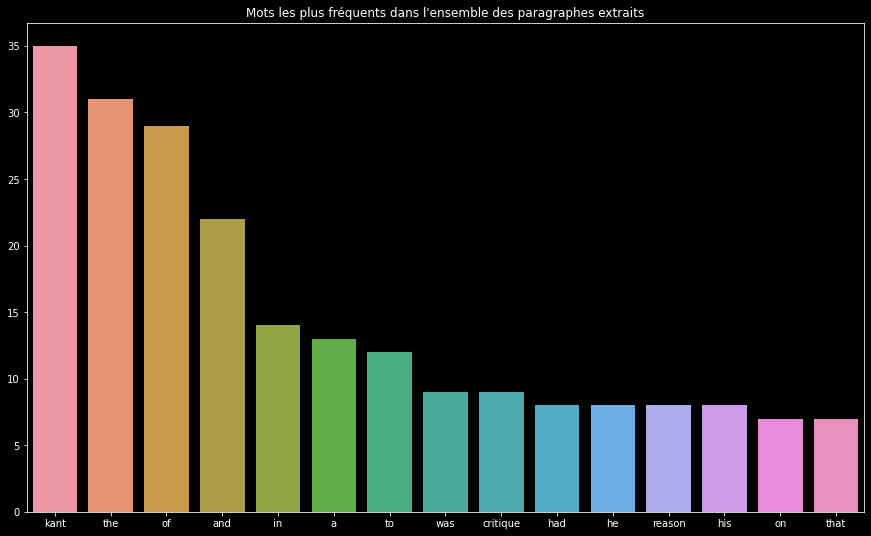

In [10]:
words = [w[0] for w in common_words]
counts = [w[1] for w in common_words]
plt.style.use('dark_background')
plt.figure(figsize=(15, 9))
seaborn.barplot(x = words, y = counts).set_title("Mots les plus fréquents dans l'ensemble des paragraphes extraits");

Nous pouvons constater que des mots tels que *the*, *of*, *and* ou encore *in* figurent parmis les termes les plus fréquents. En recherche d'information, de tels mots sont appelés **mots vides** (ou *stop words*, en anglais). Il s'agit de mots tellement communs qu'il est inutile de les utiliser dans une recherche car ils sont peu instructifs sur le contexte étudié.

Nous pouvons donc afficher les fréquences de mots mais cette fois-ci en **supprimant les mots vides** afin de mettre en lumière les mots fréquents les plus pertinents et significatifs des paragraphes extraits.

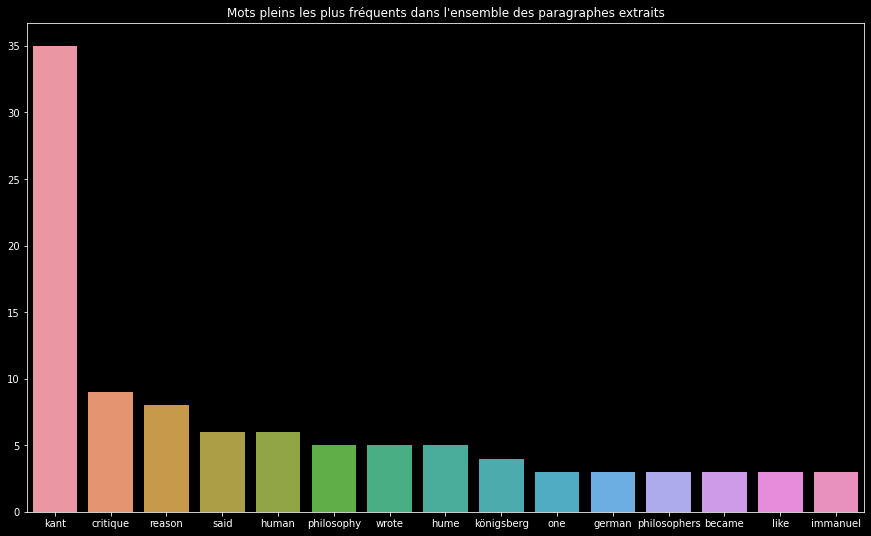

In [11]:
text_without_stopwords = t_p.without_stopwords()
cardinalities = Counter(text_without_stopwords)
words = [cardinality[0] for cardinality in cardinalities.most_common(N_MOST_COMMON)]
counts = [cardinality[1] for cardinality in cardinalities.most_common(N_MOST_COMMON)]
plt.style.use('dark_background')
plt.figure(figsize=(15, 9))
seaborn.barplot(x = words, y = counts).set_title("Mots pleins les plus fréquents dans l'ensemble des paragraphes extraits");

Les mots ainsi affichés mettent en lumière la pertinence des paragraphes extraits par l'algorithme BM25 vis à vis du thème choisi à savoir Emmanuel Kant, *kant* étant largement le mot le plus fréquent. Les autres mots fréquents tels que *critique* et *reason* faisant echo à son oeuvre principale ou encore *philosophy* sont également représentatifs du thème choisi. 

## Nuage de mots

Il est également possible de représenter les mots des paragraphes pertinents à propos d'Emmanuel Kant sous la forme de nuage de mots clés (ou *word clouds* en anglais). Le nuage de mots clés est une sorte de condensé sémantique d'un texte dans lequel les concepts clefs évoqués sont dotés d'une unité de taille (dans le sens du poids de la typographie utilisée) permettant de faire ressortir leur importance dans le texte.

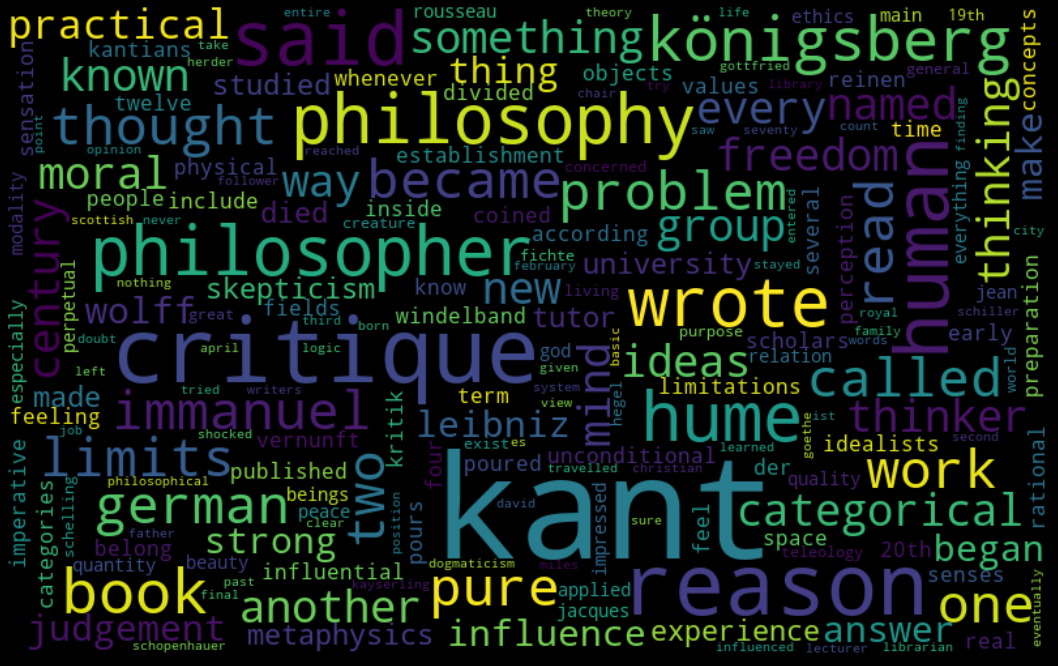

In [12]:
wordcloud = WordCloud(width=800, height=500,
                      random_state=21, max_font_size=110).generate(t_p.text)
plt.figure(figsize=(19, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off');

Cette visualisation permet d'obtenir une sorte résumé des paragraphes pertinents dont on voit directement apparaître les idées clés et donc importantes.

## Word embedding (vectorisation des mots) et visualisation

Le **word embedding** est une méthode d'apprentissage d'une représentation de mots utilisée notamment en traitement automatique des langues. Cette technique permet de représenter chaque mot d'un corpus de textes par un vecteur de nombres réels. Cette nouvelle représentation a ceci de particulier que **les mots apparaissant dans des contextes similaires possèdent des vecteurs correspondants qui sont relativement proches**. Par exemple, on pourrait s'attendre à ce que les mots « chien » et « chat » soient représentés par des vecteurs relativement peu distants dans l'espace vectoriel où sont définis ces vecteurs.

Nous pouvons donc utiliser un modèle de vectorisation de mots déjà entraîné puis des méthodes de réduction de dimmensions afin de visualiser dans l'espace latent des mots anglais, les mots fréquents des paragraphes extraits à propos d'Emmanuel Kant.

In [21]:
e = Embedding(MODEL_NAME)
e.embedding(t_p.text[:300])
words_embedding_dim_2 = e.pca()

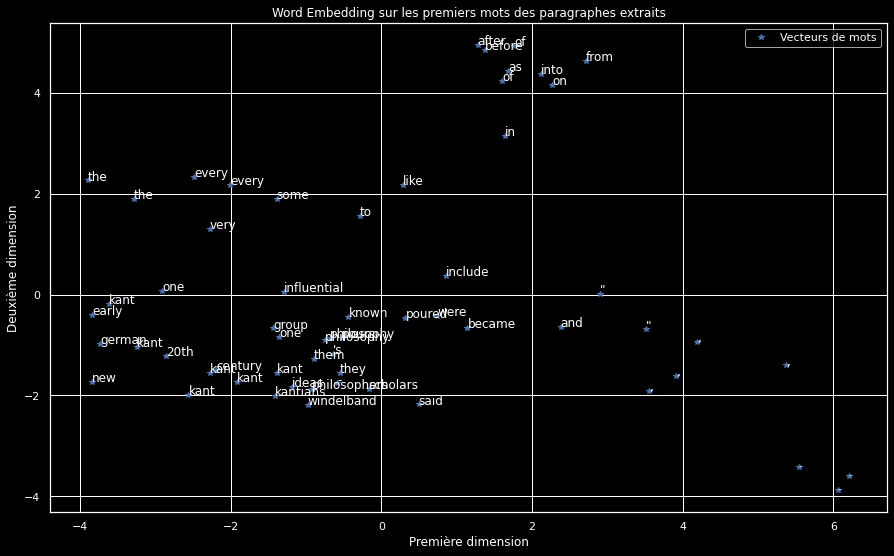

In [32]:
seaborn.set()
plt.style.use('dark_background')
plt.figure(figsize = (15, 9))
plt.plot(words_embedding_dim_2[:,0], words_embedding_dim_2[:,1], 'b', label = 'Vecteurs de mots', linewidth=0, marker = '*')
plt.title('Word Embedding sur les premiers mots des paragraphes extraits')
plt.xlabel('Première dimension')
plt.ylabel('Deuxième dimension')
plt.legend()
for i, w in enumerate(e.words):
    plt.annotate(w, xy=(words_embedding_dim_2[i, 0], words_embedding_dim_2[i, 1]))

plt.show()

# Modélisation 🔍